## Кейс классификации текстов

По отзывам на фильм нужно определить его жанр

Сравниваю простую RNN( LSTM ) и реализацию BERT найденную в доступной библиотеке на GITHub

In [3]:
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline


In [4]:
# seed values
SEED = 42
random.seed = SEED
np.random.seed(seed=SEED)

# SETUP
В setup выносим основные настройки

In [4]:
# MODEL LSTM
BATCH_SIZE_LSTM  = 128
EPOCH_LSTM       = 15

# MODEL BERT

VAL_SPLIT   = 0.15  #15%

# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 20000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 150

DATA_PATH = './data/'

# Data
#### TRAIN

In [5]:
train_df = pd.read_csv(DATA_PATH+'train.csv',)

In [6]:
train_df.head()

,name,genre,text
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    54214 non-null  object
 1   genre   54214 non-null  object
 2   text    54214 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


Text(0, 0.5, 'Counts')

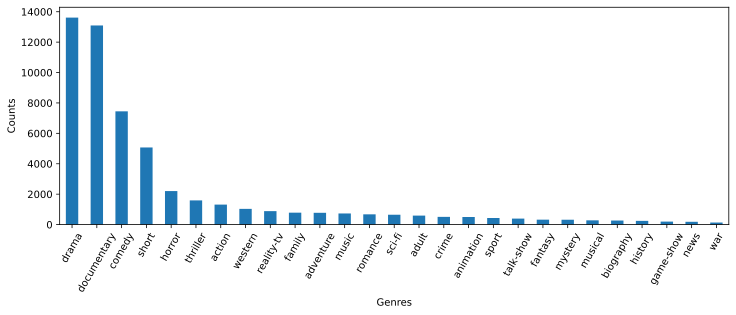

In [8]:
train_df.genre.value_counts().plot(kind='bar',figsize=(12,4),fontsize=10)
plt.xticks(rotation=60)
plt.xlabel("Genres",fontsize=10)
plt.ylabel("Counts",fontsize=10)

### Target

In [9]:
Y = pd.get_dummies(train_df.genre)
CLASS_NUM = Y.shape[1]
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (54214, 27)


In [10]:
Y.head()

,action,adult,adventure,animation,biography,comedy,crime,documentary,drama,family,...,news,reality-tv,romance,sci-fi,short,sport,talk-show,thriller,war,western
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# Preprocessing для LSTM

### Clean Data

In [13]:
# данные у нас и так достаточно чистые

### Tokenize data and convert the text to sequences

Токенизация — это самый первый шаг при обработке текста. Заключается в разбиении (разделении) длинных строк текста в более мелкие: абзацы делим на предложения, предложения на слова. В итоге мы получаем некий словарь, который позволит превратить наш текст в векторное представление для сети.

Воспользуемся [Tokenizer](https://keras.io/preprocessing/text/) которая позволяет сделать всю предобработку буквально в пару строчек. 

In [11]:
# для построения словаря мы используем весь текст
all_text = train_df.text

In [12]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(all_text)

Wall time: 5.12 s


теперь переведем наш текст в вектор

In [13]:
%%time
sequences = tokenize.texts_to_sequences(train_df.text)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=MAX_SEQUENCE_LENGTH)
print(sequences_matrix.shape)

(54214, 150)
Wall time: 3.75 s


In [14]:
# вот так теперь выглядит наш текст
print(train_df.text[1])
print(sequences_matrix[1])

 A brother and sister with a past incestuous relationship have a current murderous relationship. He murders the women who reject him and she murders the women who get too close to him.
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     3   197
     2   249     9     3   164 14104   206    42     3   914  4322   206
    11  1599

# Model LSTM
Архитектура сети достаточно простая. Можно еще поиграться с гиперпараметрами и составом слоев. 


In [19]:
def RNN():
    inputs = Input(name='inputs',shape=[MAX_SEQUENCE_LENGTH])
    layer = Embedding(MAX_WORDS,50,input_length=MAX_SEQUENCE_LENGTH)(inputs)
    
    layer = LSTM(256, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)(layer)
    layer = LSTM(256, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)(layer)
    layer = LSTM(256, dropout=0.3, recurrent_dropout=0.2)(layer)
    
    layer = Dense(256, activation='relu', name='FC1')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(CLASS_NUM, activation='sigmoid', name='out_layer')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [20]:
model = RNN()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 50)           1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 150, 256)          314368    
_________________________________________________________________
lstm_3 (LSTM)                (None, 150, 256)          525312    
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               525312    
_________________________________________________________________
FC1 (Dense)                  (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0   

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
history = model.fit(sequences_matrix,Y,
                    batch_size=BATCH_SIZE_LSTM,
                    epochs=EPOCH_LSTM,
                    validation_split=VAL_SPLIT)

Train on 46081 samples, validate on 8133 samples
Epoch 1/15
46081/46081 [==============================] - 272s 6ms/sample - loss: 2.4247 - accuracy: 0.2461 - val_loss: 2.3457 - val_accuracy: 0.2516
Epoch 2/15
46081/46081 [==============================] - 266s 6ms/sample - loss: 2.3710 - accuracy: 0.2483 - val_loss: 2.3443 - val_accuracy: 0.2516
Epoch 3/15
46081/46081 [==============================] - 267s 6ms/sample - loss: 2.3637 - accuracy: 0.2500 - val_loss: 2.3427 - val_accuracy: 0.2516
Epoch 4/15
46081/46081 [==============================] - 267s 6ms/sample - loss: 2.3527 - accuracy: 0.2495 - val_loss: 2.3270 - val_accuracy: 0.2516
Epoch 5/15
46081/46081 [==============================] - 265s 6ms/sample - loss: 2.2511 - accuracy: 0.2523 - val_loss: 2.1653 - val_accuracy: 0.2548
Epoch 6/15
46081/46081 [==============================] - 267s 6ms/sample - loss: 2.0836 - accuracy: 0.2851 - val_loss: 2.0608 - val_accuracy: 0.3872
Epoch 7/15
46081/46081 [===========================

In [24]:
model.save('rnn_lstm.h5')

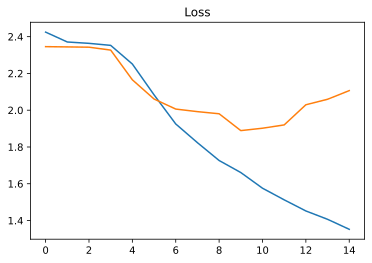

In [25]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.show();

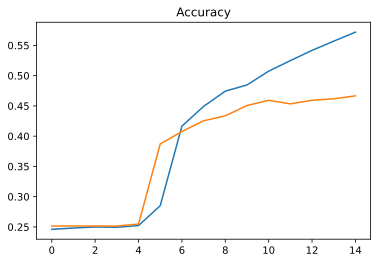

In [26]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.show();

# BERT

# Preprocessing для BERT

In [41]:
import ktrain
from ktrain import text

BATCH_SIZE_BERT  = 32
EPOCH_BERT       = 3
LR = 1e-5


In [31]:
# Подготовим таргеты
classes =  list(set(train_df.genre))
train = train_df[['text', 'genre']]
train = pd.get_dummies(train, prefix='', prefix_sep='', columns=['genre',])
train.to_csv('train_bert.csv', index=False)
train.head(1)

,text,action,adult,adventure,animation,biography,comedy,crime,documentary,drama,...,news,reality-tv,romance,sci-fi,short,sport,talk-show,thriller,war,western
0,Listening in to a conversation between his do...,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


# MODEL ktrain (BERT)
Далее Основываясь на примерах:
* [https://github.com/amaiya/ktrain/blob/master/tutorial-04-text-classification.ipynb](https://github.com/amaiya/ktrain/blob/master/tutorials/tutorial-04-text-classification.ipynb)
* [https://github.com/amaiya/ktrain/blob/master/examples/text/IMDb-BERT.ipynb](https://github.com/amaiya/ktrain/blob/master/examples/text/IMDb-BERT.ipynb)
* [https://github.com/amaiya/ktrain/blob/master/examples/text/toxic_comments-bigru.ipynb](https://github.com/amaiya/ktrain/blob/master/examples/text/toxic_comments-bigru.ipynb)
* и исходниках

строим свой эксперимет

В <b>Ktrain</b> доступно множество готовых решений под классификацию текста.  
Берем BERT тк сейчас эта одна из лучших языковых моделей: [https://habr.com/ru/post/436878/](https://habr.com/ru/post/436878/)

### Работа с библиотекой ktrain

In [35]:
# подготавливаем данные
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(train_df=train, 
                                                                   text_column='text',
                                                                   label_columns=classes,
                                                                   val_pct=VAL_SPLIT, 
                                                                   max_features=MAX_WORDS, 
                                                                   maxlen=MAX_SEQUENCE_LENGTH,
                                                                   preprocess_mode='bert',
                                                                   ngram_range=1)

preprocessing train...
language: en


preprocessing test...
language: en


In [38]:
# определяем модель
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 150
done.


In [40]:
# устанавливаем параметры обучения
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=BATCH_SIZE_BERT)
learner.print_layers()

0 (trainable=True) : <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000215BE2DF588>
1 (trainable=True) : <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000215BE2DF508>
2 (trainable=True) : <keras_bert.layers.embedding.TokenEmbedding object at 0x00000215BE2DF6C8>
3 (trainable=True) : <tensorflow.python.keras.layers.embeddings.Embedding object at 0x00000215BE28DF08>
4 (trainable=True) : <tensorflow.python.keras.layers.merge.Add object at 0x00000215BE2984C8>
5 (trainable=True) : <keras_pos_embd.pos_embd.PositionEmbedding object at 0x00000215BE304B48>
6 (trainable=True) : <tensorflow.python.keras.layers.core.Dropout object at 0x00000215BE2CBD48>
7 (trainable=True) : <keras_layer_normalization.layer_normalization.LayerNormalization object at 0x00000215BE327388>
8 (trainable=True) : <keras_multi_head.multi_head_attention.MultiHeadAttention object at 0x00000215BE28D308>
9 (trainable=True) : <tensorflow.python.keras.layers.core.Dropout object at 0x00

In [42]:
# непосредственно обучение
learner.autofit(LR, EPOCH_BERT)



begin training using triangular learning rate policy with max lr of 1e-05...
Train on 46081 samples, validate on 8133 samples
Epoch 1/3
46081/46081 [==============================] - 1118s 24ms/sample - loss: 1.6609 - accuracy: 0.5332 - val_loss: 1.2062 - val_accuracy: 0.6399
Epoch 2/3
46081/46081 [==============================] - 1104s 24ms/sample - loss: 1.1305 - accuracy: 0.6641 - val_loss: 1.1048 - val_accuracy: 0.6662
Epoch 3/3
46081/46081 [==============================] - 1105s 24ms/sample - loss: 0.9875 - accuracy: 0.7005 - val_loss: 1.0959 - val_accuracy: 0.6680


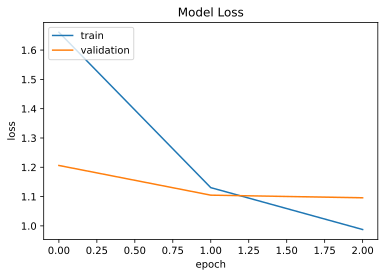

In [43]:
learner.plot()

In [44]:
learner.save_model('rnn_bert')

## Вывод
Даже на 3 эпохах BERT выиграл 0.2 - это очень много.

In [ ]:
Обучение медленное, поэтому буду дальше тестировать и проверять в разных ситуациях